In [1]:
import numpy as np
import jax
from jax.config import config
import jax.random
import jax.lax as lax
config.update("jax_enable_x64", True)

#config.update("jax_debug_nans", True)

from jax import grad, jit, vmap
import jax.numpy as jnp
import matplotlib.pyplot as plt

from matplotlib import style
style.use('dark_background')

#from sklearn.metrics import pairwise_distances
import os


In [2]:
import ott
import ott.geometry
from ott.geometry import pointcloud
from ott.core import sinkhorn
from ott.tools import transport
from ott.geometry import costs
from ott.geometry import grid

In [3]:
import numpyro
#numpyro.set_host_device_count(4)
import numpyro.distributions as dist
from numpyro.distributions import (
    Categorical,
    Multinomial,
    Dirichlet,
    Normal,
    Uniform,
    Exponential,
    LogNormal,
    TruncatedNormal
 )
from numpyro.infer import MCMC, NUTS, Predictive, BarkerMH, SA


In [4]:
@jax.tree_util.register_pytree_node_class
class DiscreteCostFn(costs.CostFn):
  def __init__(self, C):
      super().__init__()
      self._C = C

  def norm(self, x):
    return jnp.zeros_like(x).squeeze()

  def pairwise(self, x, y):
    return self._C[x, y][0]

  classmethod
  def tree_unflatten(cls, aux_data):
    print(aux_data)
    return cls(aux_data)

In [5]:
def forward_map(X, Y, mu, nu, C, eps):
    
    cost = DiscreteCostFn(C)
    pc_geom = pointcloud.PointCloud(X, Y, cost_fn=cost, epsilon=eps)  
    geom = ott.geometry.Geometry(cost_matrix=pc_geom.cost_matrix)
#    out = sinkhorn.sinkhorn(geom, a=mu, b=nu, use_danskin=False, lse_mode=True, implicit_differentiation=False)
    out = sinkhorn.sinkhorn(geom, a=mu, b=nu, inner_iterations=10, max_iterations=10000, jit=False)

    T = geom.transport_from_potentials(out.f, out.g)

    return T

In [6]:
X = jnp.expand_dims(jnp.arange(1, N+1),1)
Y = jnp.expand_dims(jnp.arange(1, M+1),1)

a = jnp.ones((N,))/N

b = jnp.arange(1,M+1)**2
b = b/jnp.sum(b)
    
delta = 1e-9

pert = jnp.array([[float(i==5 and j==5) for i in range(N)] for j in range(M)])
C = jnp.abs(X/N - Y.T/M)

(forward_map(X, Y, a, b, C  + delta*pert, eps=1e-3)[4,5] - forward_map(X, Y, a, b, C, eps=1e-3)[4,5])/delta

NameError: name 'N' is not defined

In [7]:
def generate_data(N, M, num_samples=1000):

    X = jnp.expand_dims(jnp.arange(1, N+1),1)
    Y = jnp.expand_dims(jnp.arange(1, M+1),1)


    # marginals 
    a = jnp.ones((N,))/N

    b = jnp.arange(1,M+1)**2
    b = b/jnp.sum(b)
    
    rng = jax.random.PRNGKey(0)
    C = jnp.abs(X/N - Y.T/M)

    cost = DiscreteCostFn(C)
    pc_geom = pointcloud.PointCloud(X, Y, cost_fn=cost, epsilon=1e-9)  
    geom = ott.geometry.Geometry(cost_matrix=pc_geom.cost_matrix)

    # sinkhorn
    out = sinkhorn.sinkhorn(geom, a=a, b=b, inner_iterations=10, max_iterations=10000, jit=True)
    T = geom.transport_from_potentials(out.f, out.g)

    data = np.random.multinomial(num_samples, T.reshape(N*M))

    return T, data, C, X,Y


In [8]:
def vec_to_tril_matrix(t, n, diagonal=0):
    # NB: the following formula only works for diagonal <= 0
    n2 = n * n
    idx = jnp.reshape(jnp.arange(n2), (n, n))[jnp.tril_indices(n, diagonal)]
    x = lax.scatter_add(jnp.zeros(t.shape[:-1] + (n2,)), jnp.expand_dims(idx, axis=-1), t,
                        lax.ScatterDimensionNumbers(update_window_dims=range(t.ndim - 1),
                                                    inserted_window_dims=(t.ndim - 1,),
                                                    scatter_dims_to_operand_dims=(t.ndim - 1,)))
    return jnp.reshape(x, x.shape[:-1] + (n, n))


In [11]:
def model(X, Y, N, M, eps, data=None):

    pi0 = numpyro.sample("mu", Dirichlet(jnp.ones(N)))
    pi1 = numpyro.sample("nu", Dirichlet(jnp.ones(M)))

    cvec = numpyro.sample("cost", Uniform(0., 1.), sample_shape=(int(N*(M+1)/2)-1,)) 
    cost_vec = jnp.append(cvec/(1e-9 + jnp.linalg.norm(cvec)), jnp.array([0.]))
    L = vec_to_tril_matrix(cost_vec, N)
    T = forward_map(X, Y, pi0, pi1, L + L.T, eps)
    t = T.reshape((T.size,))

    numpyro.sample("Z", Multinomial(probs=t), obs=data)

In [12]:
rng = jax.random.PRNGKey(0)

N, M = 10, 10
T, data, C, X, Y = generate_data(N, M, 10000)


In [13]:
mcmc = MCMC(
        NUTS(model, dense_mass=True),
        num_warmup=1000,
        num_samples=10000,
        num_chains=1,
        progress_bar=False if "NUMPYRO_SPHINXBUILD" in os.environ else True,
)

mcmc.run(rng, X=X, Y=Y, N=N, M =M, eps=1e-9, data=data)
mcmc.print_summary()

sample: 100%|██████████| 11000/11000 [34:51<00:00,  5.26it/s, 1023 steps of size 2.95e-04. acc. prob=0.90]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
   cost[0]      0.86      0.01      0.86      0.85      0.87      5.66      1.06
   cost[1]      0.34      0.01      0.34      0.33      0.36      4.41      1.50
   cost[2]      0.04      0.00      0.04      0.03      0.04     14.28      1.18
   cost[3]      0.86      0.01      0.86      0.85      0.88      2.87      2.51
   cost[4]      0.06      0.00      0.06      0.06      0.07      6.82      1.27
   cost[5]      0.03      0.00      0.03      0.03      0.03      6.30      1.00
   cost[6]      0.91      0.00      0.91      0.90      0.91      4.00      1.48
   cost[7]      0.35      0.01      0.35      0.33      0.36      3.16      1.89
   cost[8]      0.33      0.01      0.33      0.31      0.35      4.00      1.69
   cost[9]      0.23      0.00      0.23      0.22      0.24      4.83      1.60
  cost[10]      0.46      0.01      0.46      0.44      0.48      5.41      1.26
  cost[11]      0.45      0

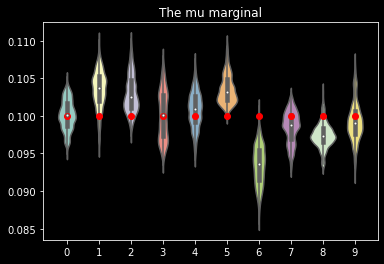

In [36]:
import seaborn as sns

samples_1 = mcmc.get_samples()
mu_post = samples_1['mu']
sns.violinplot(data=mu_post)
plt.plot(range(mu_post.shape[1]), jnp.ones((N,))/N, 'o', color='red')
plt.title("The mu marginal")
plt.savefig("mu_marginal.jpeg")

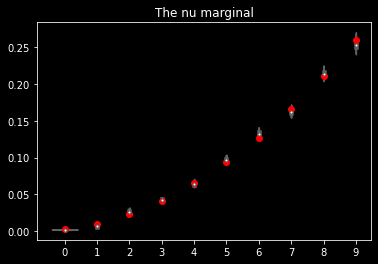

In [37]:
# compare marginal nu

b = jnp.arange(1,M+1)**2
b = b/jnp.sum(b)

nu_post = samples_1['nu']
sns.violinplot(data=nu_post)
plt.plot(range(nu_post.shape[1]), b, 'o', color='red')
plt.title("The nu marginal")
plt.savefig("nu_marginal.jpeg")

In [17]:
# Compute the mean cost matrix 

def to_symm_matrix(vec, N):
    vec = jnp.append(vec, jnp.array([0.]))
    L = vec_to_tril_matrix(vec, N)
    return L + L.T

to_symm_matrix_vec = vmap(lambda x: to_symm_matrix(x, N), in_axes=0, out_axes=0)

posterior_cost = to_symm_matrix_vec(samples_1['cost'])


In [18]:
C[3,1]

DeviceArray(0.2, dtype=float64)

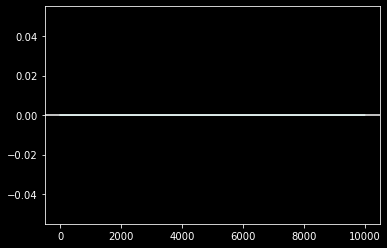

In [29]:
i,j = 9,9
plt.plot(posterior_cost[:,i,j])
plt.axhline(C[i,j])

In [30]:
posterior_cost[0,:,:3]

DeviceArray([[1.73680272, 0.33378946, 0.87357591],
             [0.33378946, 0.07255348, 0.06211641],
             [0.87357591, 0.06211641, 0.0653399 ],
             [0.89673591, 0.359625  , 0.35554328],
             [0.44602022, 0.45446844, 0.44303903],
             [0.83966221, 0.61170268, 0.60861945],
             [0.56643665, 0.76729401, 0.75725629],
             [0.32910116, 0.70785482, 0.70489487],
             [0.3277995 , 0.70486719, 0.69863926],
             [0.86194451, 0.68964634, 0.687308  ]], dtype=float64)

In [32]:
#generate predictive posterior
mu = samples_1["mu"]
nu = samples_1["nu"]
C  = to_symm_matrix_vec(samples_1['cost'])

X = jnp.expand_dims(jnp.arange(1, N+1),1)
Y = jnp.expand_dims(jnp.arange(1, M+1),1)

num_mcmc_samples = mu.shape[0]
num_data_samples = 10000

predictive_post = np.zeros((num_mcmc_samples, N*M))

for n in range(num_mcmc_samples):
    cost = DiscreteCostFn(C[n,:,:])
    pc_geom = pointcloud.PointCloud(X, Y, cost_fn=cost, epsilon=1e-9)  
    geom = ott.geometry.Geometry(cost_matrix=pc_geom.cost_matrix)

    # sinkhorn
    out = sinkhorn.sinkhorn(geom, a=mu[n,:], b=nu[n,:],  inner_iterations=10, max_iterations=10000,jit=True)
    T = geom.transport_from_potentials(out.f, out.g)

    predictive_post[n,:] = np.random.multinomial(num_data_samples, T.reshape(N*M))    

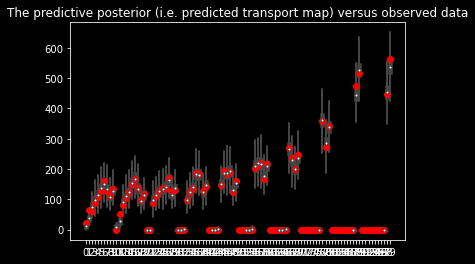

In [38]:
sns.violinplot(data=predictive_post)
plt.plot(range(predictive_post.shape[1]), data, 'o', color='red')
plt.title("The predictive posterior (i.e. predicted transport map) versus observed data")
plt.savefig("predictive_posterior.jpeg")

In [39]:
predictive_post.mean(0).astype(int)

array([ 11,  37,  76,  98, 114, 137, 152, 134, 109, 129,   9,  27,  90,
       112, 124, 155, 168, 135,  96, 114,   0,   0,  97, 113, 126, 134,
       142, 165, 114, 136,   0,   0,   0,  99, 123, 140, 185, 182, 123,
       145,   0,   0,   0,   2, 150, 188, 187, 194, 130, 154,   0,   0,
         0,   0,   2, 209, 219, 217, 177, 210,   0,   0,   0,   0,   0,
         1, 266, 228, 200, 237,   0,   0,   0,   0,   0,   0,   0, 361,
       285, 338,   0,   0,   0,   0,   0,   0,   0,   0, 445, 528,   0,
         0,   0,   0,   0,   0,   0,   0, 454, 538])

In [74]:
data

array([ 27,  49,  68, 102, 109, 139, 140, 155,  91,  95,   0,  52,  73,
        90, 106, 127, 141, 137,  94, 144,   0,   0,  78, 106, 146, 135,
       165, 132, 117, 128,   0,   0,   0, 125, 123, 158, 152, 165, 122,
       155,   0,   0,   0,   0, 151, 181, 183, 202, 141, 155,   0,   0,
         0,   0,   0, 208, 193, 205, 167, 197,   0,   0,   0,   0,   0,
         0, 251, 308, 220, 218,   0,   0,   0,   0,   0,   0,   0, 370,
       261, 346,   0,   0,   0,   0,   0,   0,   0,   0, 498, 562,   0,
         0,   0,   0,   0,   0,   0,   0, 457, 580])

<AxesSubplot:>

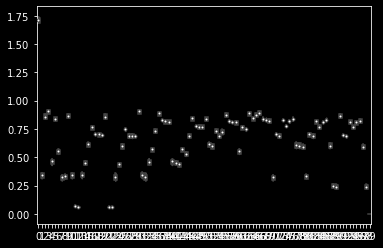

In [46]:
sns.violinplot(data=C.reshape(C.shape[0], C.shape[1]*C.shape[2]))
plt.plot()

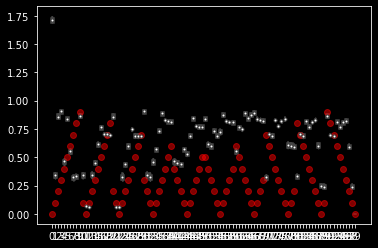

In [51]:
_, _, cost_mat, _, _ = generate_data(N, M, 10000)

sns.violinplot(data=C.reshape(C.shape[0], C.shape[1]*C.shape[2]))
plt.plot(range(N*M), cost_mat.reshape(N*M), 'o', color='red', alpha=0.5)
